Training samples: 33476
Features: 70

Training RandomForest...
  CV MAE:    37.09 (+/- 0.64)
  Train MAE: 34.41 | Test MAE: 38.23 | Gap: 3.82
  Train R²:  0.4999 | Test R²: 0.3931 | Gap: 0.1068
 Mild overfitting

Training XGBoost...
  CV MAE:    37.78 (+/- 0.78)
  Train MAE: 34.74 | Test MAE: 38.83 | Gap: 4.09
  Train R²:  0.5446 | Test R²: 0.4260 | Gap: 0.1187
 Mild overfitting

Training CatBoost...
  CV MAE:    39.28 (+/- 0.65)
  Train MAE: 38.13 | Test MAE: 40.95 | Gap: 2.82
  Train R²:  0.4526 | Test R²: 0.3983 | Gap: 0.0543
 Good generalization!


ENSEMBLE APPROACH (Averaging Models)



Ensemble Results:
  Train MAE: 35.11 | Test MAE: 38.62
  Train R²:  0.5091 | Test R²: 0.4152
  MAE Gap:   3.51
  R² Gap:    0.0939


COMPARISON TABLE


       Model    CV_MAE  CV_MAE_Std  Train_MAE  Test_MAE  MAE_Gap  Train_R2  Test_R2   R2_Gap    CV_R2
RandomForest 37.089293    0.640433  34.413030 38.231694 3.818663  0.499886 0.393071 0.106815 0.393829
     XGBoost 37.777734    0.781688  34.737904

/var/folders/vw/3ry2l6hs6qz2yjr9tcj8bq6c0000gp/T/ipykernel_93678/3625918103.py:203: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(df_models['Model'], rotation=15, ha='right')
/var/folders/vw/3ry2l6hs6qz2yjr9tcj8bq6c0000gp/T/ipykernel_93678/3625918103.py:214: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels(df_models['Model'], rotation=15, ha='right')
/var/folders/vw/3ry2l6hs6qz2yjr9tcj8bq6c0000gp/T/ipykernel_93678/3625918103.py:224: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax4.set_xticklabels(df_models['Model'], rotation=15, ha='right')


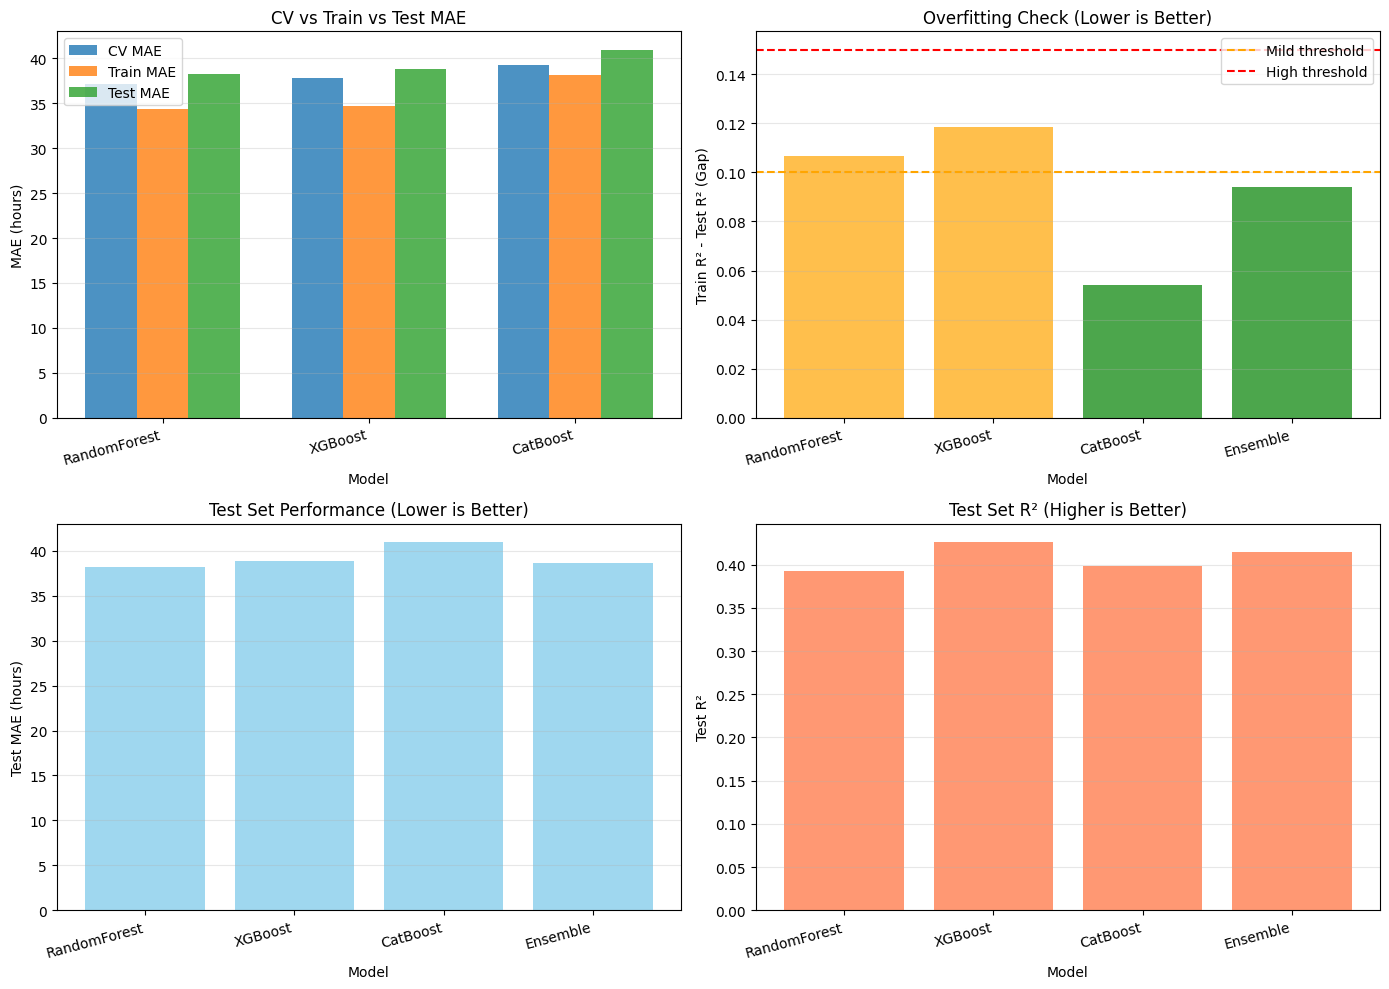



Overall

 Best Generalization: CatBoost
   Test MAE: 40.95
   Test R²:  0.3983
   R² Gap:   0.0543

 Best Test Performance: RandomForest
   Test MAE: 38.23
   Test R²:  0.3931
   R² Gap:   0.1068

 Key Takeaways:
   - If R² gap < 0.10: Excellent generalization
   - If R² gap 0.10-0.15: Acceptable
   - If R² gap > 0.15: Consider further regularization
   - Ensemble often reduces overfitting


In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import cross_val_score, KFold
import matplotlib.pyplot as plt

df = pd.read_csv("../../data/data_reduced.csv")

from sklearn.model_selection import train_test_split

X = df.drop(columns=["spell_length_of_stay_hours"])
y = df["spell_length_of_stay_hours"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

print(f"Training samples: {len(X_train)}")
print(f"Features: {X_train.shape[1]}")

models = {
    "RandomForest": RandomForestRegressor(
        n_estimators=200,
        max_depth=8,           # Reduced from 10
        min_samples_split=20,  # Increased from 10
        min_samples_leaf=10,   # Added constraint
        max_features=0.7,      # Use 70% of features per split
        random_state=42,
        n_jobs=-1
    ),
    "XGBoost": XGBRegressor(
        n_estimators=200,
        learning_rate=0.05,    # Slower learning
        max_depth=4,           # Reduced from 5
        min_child_weight=5,    # Added regularization
        subsample=0.7,         # Reduced from 0.8
        colsample_bytree=0.7,  # Reduced from 0.8
        gamma=1,               # Added regularization
        reg_alpha=0.1,         # L1 regularization
        reg_lambda=1,          # L2 regularization
        random_state=42
    ),
    "CatBoost": CatBoostRegressor(
        iterations=200,
        learning_rate=0.05,
        depth=4,               # Reduced from 5
        l2_leaf_reg=3,         # Added regularization
        random_strength=1,     # Added randomness
        verbose=False,
        random_state=42
    )
}

kfold = KFold(n_splits=5, shuffle=True, random_state=42)
results = []

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Cross-validation
    cv_mae = -cross_val_score(
        model, X_train, y_train, 
        cv=kfold, 
        scoring='neg_mean_absolute_error',
        n_jobs=-1
    )
    
    cv_r2 = cross_val_score(
        model, X_train, y_train,
        cv=kfold,
        scoring='r2',
        n_jobs=-1
    )
    
    # Train on full training set
    model.fit(X_train, y_train)
    
    # Predictions
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)
    
    # Metrics
    train_mae = mean_absolute_error(y_train, train_preds)
    train_r2 = r2_score(y_train, train_preds)
    test_mae = mean_absolute_error(y_test, test_preds)
    test_r2 = r2_score(y_test, test_preds)
    
    # Calculate gaps
    mae_gap = test_mae - train_mae
    r2_gap = train_r2 - test_r2
    
    print(f"  CV MAE:    {cv_mae.mean():.2f} (+/- {cv_mae.std():.2f})")
    print(f"  Train MAE: {train_mae:.2f} | Test MAE: {test_mae:.2f} | Gap: {mae_gap:.2f}")
    print(f"  Train R²:  {train_r2:.4f} | Test R²: {test_r2:.4f} | Gap: {r2_gap:.4f}")
    
    # Overfitting assessment
    if r2_gap < 0.10 and mae_gap < 5:
        print(" Good generalization!")
    elif r2_gap < 0.15 and mae_gap < 8:
        print(" Mild overfitting")
    else:
        print(" Significant overfitting")
    
    results.append({
        'Model': name.replace('_Conservative', ''),
        'CV_MAE': cv_mae.mean(),
        'CV_MAE_Std': cv_mae.std(),
        'Train_MAE': train_mae,
        'Test_MAE': test_mae,
        'MAE_Gap': mae_gap,
        'Train_R2': train_r2,
        'Test_R2': test_r2,
        'R2_Gap': r2_gap,
        'CV_R2': cv_r2.mean()
    })

df_models = pd.DataFrame(results)

# STRATEGY 2: Ensemble of models

print("\n")
print("ENSEMBLE APPROACH (Averaging Models)")
print("\n")

# Get predictions from all models
ensemble_train_preds = np.column_stack([
    model.predict(X_train) for model in models.values()
])
ensemble_test_preds = np.column_stack([
    model.predict(X_test) for model in models.values()
])

# Average predictions
ensemble_train_avg = ensemble_train_preds.mean(axis=1)
ensemble_test_avg = ensemble_test_preds.mean(axis=1)

# Metrics
ensemble_train_mae = mean_absolute_error(y_train, ensemble_train_avg)
ensemble_train_r2 = r2_score(y_train, ensemble_train_avg)
ensemble_test_mae = mean_absolute_error(y_test, ensemble_test_avg)
ensemble_test_r2 = r2_score(y_test, ensemble_test_avg)

print(f"\nEnsemble Results:")
print(f"  Train MAE: {ensemble_train_mae:.2f} | Test MAE: {ensemble_test_mae:.2f}")
print(f"  Train R²:  {ensemble_train_r2:.4f} | Test R²: {ensemble_test_r2:.4f}")
print(f"  MAE Gap:   {ensemble_test_mae - ensemble_train_mae:.2f}")
print(f"  R² Gap:    {ensemble_train_r2 - ensemble_test_r2:.4f}")

# Add ensemble to results
results.append({
    'Model': 'Ensemble',
    'CV_MAE': np.nan,
    'CV_MAE_Std': np.nan,
    'Train_MAE': ensemble_train_mae,
    'Test_MAE': ensemble_test_mae,
    'MAE_Gap': ensemble_test_mae - ensemble_train_mae,
    'Train_R2': ensemble_train_r2,
    'Test_R2': ensemble_test_r2,
    'R2_Gap': ensemble_train_r2 - ensemble_test_r2,
    'CV_R2': np.nan
})

df_models = pd.DataFrame(results)

print("\n")
print("COMPARISON TABLE")
print("\n")
print(df_models.to_string(index=False))

# VISUALIZATION

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: MAE Comparison
ax1 = axes[0, 0]
models_to_plot = df_models[df_models['Model'] != 'Ensemble']
x = np.arange(len(models_to_plot))
width = 0.25
ax1.bar(x - width, models_to_plot['CV_MAE'], width, label='CV MAE', alpha=0.8)
ax1.bar(x, models_to_plot['Train_MAE'], width, label='Train MAE', alpha=0.8)
ax1.bar(x + width, models_to_plot['Test_MAE'], width, label='Test MAE', alpha=0.8)
ax1.set_xlabel('Model')
ax1.set_ylabel('MAE (hours)')
ax1.set_title('CV vs Train vs Test MAE')
ax1.set_xticks(x)
ax1.set_xticklabels(models_to_plot['Model'], rotation=15, ha='right')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Plot 2: R² Gap (Overfitting Indicator)
ax2 = axes[0, 1]
colors = ['green' if gap < 0.10 else 'orange' if gap < 0.15 else 'red' 
          for gap in df_models['R2_Gap']]
ax2.bar(df_models['Model'], df_models['R2_Gap'], color=colors, alpha=0.7)
ax2.axhline(y=0.10, color='orange', linestyle='--', label='Mild threshold')
ax2.axhline(y=0.15, color='red', linestyle='--', label='High threshold')
ax2.set_xlabel('Model')
ax2.set_ylabel('Train R² - Test R² (Gap)')
ax2.set_title('Overfitting Check (Lower is Better)')
ax2.set_xticklabels(df_models['Model'], rotation=15, ha='right')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# Plot 3: Test Performance (MAE)
ax3 = axes[1, 0]
ax3.bar(df_models['Model'], df_models['Test_MAE'], 
        color='skyblue', alpha=0.8)
ax3.set_xlabel('Model')
ax3.set_ylabel('Test MAE (hours)')
ax3.set_title('Test Set Performance (Lower is Better)')
ax3.set_xticklabels(df_models['Model'], rotation=15, ha='right')
ax3.grid(axis='y', alpha=0.3)

# Plot 4: Test R²
ax4 = axes[1, 1]
ax4.bar(df_models['Model'], df_models['Test_R2'], 
        color='coral', alpha=0.8)
ax4.set_xlabel('Model')
ax4.set_ylabel('Test R²')
ax4.set_title('Test Set R² (Higher is Better)')
ax4.set_xticklabels(df_models['Model'], rotation=15, ha='right')
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('models_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

#  Overall

print("\n")
print("Overall")

best_generalization = df_models.loc[df_models['R2_Gap'].idxmin()]
best_performance = df_models.loc[df_models['Test_MAE'].idxmin()]

print(f"\n Best Generalization: {best_generalization['Model']}")
print(f"   Test MAE: {best_generalization['Test_MAE']:.2f}")
print(f"   Test R²:  {best_generalization['Test_R2']:.4f}")
print(f"   R² Gap:   {best_generalization['R2_Gap']:.4f}")

print(f"\n Best Test Performance: {best_performance['Model']}")
print(f"   Test MAE: {best_performance['Test_MAE']:.2f}")
print(f"   Test R²:  {best_performance['Test_R2']:.4f}")
print(f"   R² Gap:   {best_performance['R2_Gap']:.4f}")

print("\n Key Takeaways:")
print("   - If R² gap < 0.10: Excellent generalization")
print("   - If R² gap 0.10-0.15: Acceptable")
print("   - If R² gap > 0.15: Consider further regularization")
print("   - Ensemble often reduces overfitting")

df_models.to_csv('models_results.csv', index=False)